### Applied Data Science Capstone by IBM/Coursera


## Capstone Project
## Topic:  Useful tourist information for the boroughs in Berlin
<br> </br>



## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

# Introduction <a name="introduction"></a>

**Berlin** is a great city for tourists. It is not a surprise that it is ranked as the most visited German city by <a href="https://www.worldatlas.com/articles/the-10-most-visited-cities-in-germany.html" target="_blank" rel="noopener">Worldatlas</a> with 31.1 milion tourists for 2016. However, as a tourist, you may find it **diffucult** to find out in which part of the city you should spend most of your time while being in Berlin. Especially for the tourists visiting Berlin only for a day or a weekend. The city is really big and it is divided in 96 boroughs, full of great places to visit. The questions I will try to answer are:
<p> <b>1) Which borough(s) has the highest variaty of venues? </b></p>
<p> <b>2) What is the most common type of restaurants in Berlin? </b></p>
<p> <b>3) Which borough(s) is near to Art Gallery? </b></p>

The main audience which may benefit by answering the questions above is the **one-day tourists.** It will be extremely valuable for them to know in which district should they spend their only day in Berlin in order to get the best out of it and also to have more specific expectations from Berlin as a touristic destination.

For the sake of this project the terms boroughs, neighborhoods and districts are used with the same meaning.

# Data <a name="data"></a>

Based on definition of the problem, factors that will influence the solution are:
* geolocation of the Berlin boroughs and venues
* number of unique categories of venues in the borough

In order to get this data, I decided to use two data providers:
* the list of the names of boroughs will be obtained from **Wikipedia**
* number of unique categories of venues in the boroughs and the location of the venues will be obtained using **Foursquare API**

### Obtaining the names of the Berlin boroughs from Wikipedia

#### Installing the necessary libriaries
Here is a list of the libraries needed in order to answer the questions in this project.

In [1]:
! pip install pandas
import pandas as pd

from pandas.io.html import read_html

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 
import requests

from pandas.io.json import json_normalize 

!conda install -c conda-forge folium=0.5.0 --yes
import folium

import seaborn as sns
import matplotlib.pyplot as plt

print("Libraries installed")

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries installed


#### Obtaining the data from Wikipedia
Wikipedia seems to be a good resource for obtaining such information due to its simple structure and easy readable data. 

In [2]:
page = "https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin"

wikitables = read_html(page, attrs={"class":"wikitable"})
print("Exracted {num} wikitables".format(num=len(wikitables)))

Exracted 13 wikitables


#### Converting the Wikitable into a Pandas DataFrame
All of the boroughs have been located in 12 different tables. Therefore, each of these tables are assigned in a seperate dataframe.

In [3]:
df1 = pd.DataFrame(wikitables[1])
df2 = pd.DataFrame(wikitables[2])
df3 = pd.DataFrame(wikitables[3])
df4 = pd.DataFrame(wikitables[4])
df5 = pd.DataFrame(wikitables[5])
df6 = pd.DataFrame(wikitables[6])
df7 = pd.DataFrame(wikitables[7])
df8 = pd.DataFrame(wikitables[8])
df9 = pd.DataFrame(wikitables[9])
df10 = pd.DataFrame(wikitables[10])
df11 = pd.DataFrame(wikitables[11])
df12 = pd.DataFrame(wikitables[12])

#### Concatenating all wikitables into one Pandas DataFrame 

In [4]:
district_list = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12], ignore_index=True)
district_list.head()

,Locality,Area in km²,Population as of 2008,Density inhabitants per km²,Map
0,(0101) Mitte,10.70,79582,7445,NaN
1,(0102) Moabit,7.72,69425,8993,NaN
2,(0103) Hansaviertel,0.53,5889,11111,NaN
3,(0104) Tiergarten,5.17,12486,2415,NaN
4,(0105) Wedding,9.23,76363,8273,NaN


#### Removing the unnecessary columns
Cleaning the dataframe from information which is not relevant for the project is a very important step in this project. This will make the code easier to read and to understand.

In [5]:
dropped_df = district_list.drop(columns=['Population as of 2008', 'Density inhabitants per km²', 'Map'], axis=1)
dropped_df.head()

,Locality,Area in km²
0,(0101) Mitte,10.70
1,(0102) Moabit,7.72
2,(0103) Hansaviertel,0.53
3,(0104) Tiergarten,5.17
4,(0105) Wedding,9.23


#### Renaming the Locality column into District

In [6]:
renamed_df = dropped_df.rename(columns={"Locality": "District"})
renamed_df.head()

,District,Area in km²
0,(0101) Mitte,10.70
1,(0102) Moabit,7.72
2,(0103) Hansaviertel,0.53
3,(0104) Tiergarten,5.17
4,(0105) Wedding,9.23


#### Removing the codes from the District names

In [7]:
renamed_df['District'] = pd.DataFrame(renamed_df['District'].str[7:])
renamed_df.head()

,District,Area in km²
0,Mitte,10.70
1,Moabit,7.72
2,Hansaviertel,0.53
3,Tiergarten,5.17
4,Wedding,9.23


### Importing the Geospatial data of the Districts

In [8]:
geo_data = pd.read_csv('/Users/kirilyunakov/Downloads/Berlin_District_Coordinates.csv')
geo_data.head()

,Locale,Lat,Long
0,Mitte,52.519444,13.406667
1,Moabit,52.533333,13.333333
2,Hansaviertel,52.516667,13.338889
3,Tiergarten,52.516667,13.366667
4,Wedding,52.550000,13.366667


#### Renaming the column based on which will perform the merge (District)

In [9]:
renamed_geo_data = geo_data.rename(columns={'Locale': 'District'})
renamed_geo_data.head()

,District,Lat,Long
0,Mitte,52.519444,13.406667
1,Moabit,52.533333,13.333333
2,Hansaviertel,52.516667,13.338889
3,Tiergarten,52.516667,13.366667
4,Wedding,52.550000,13.366667


#### Merging the Geospatial data with the data from Wikipedia based on the District name

In [10]:
result = pd.merge(renamed_df, renamed_geo_data, on='District', how='left')
result.head()

,District,Area in km²,Lat,Long
0,Mitte,10.70,52.519444,13.406667
1,Moabit,7.72,52.533333,13.333333
2,Hansaviertel,0.53,52.516667,13.338889
3,Tiergarten,5.17,52.516667,13.366667
4,Wedding,9.23,52.550000,13.366667


Now, we have a dataset, consisting of all borouhgs in Berlin, together with their location data and size. 

# Methodology <a name="methodology"></a>

In this project we will allocate our efforts on trying to answer the questions we set beforehand. In order to do so we will need to identify the size of the radios within we have to search for venues from each district.

The very first thing we did was to collect all of the information needed:
- list of all borouhgs in berlin
- the location of the boroughs
- the size of the boroughs
- a list of all venues within a certain radius of the district
- the category type of these venues


Secondly, we will use distribution analysis in order to identify the size of the radius we will search for the venues. Also, we will use one hot encoding for the purpose of converting the categorial values into numerical and measure how common each venue type is.

# Analysis <a name="analysis"></a>

In [11]:
neighborhoods = result

#### Create a map of Berlin with the districts locations
In order to find out whether there are many districts that extremely close to each other.

In [12]:
address = 'Berlin'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berlin are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berlin are 52.5170365, 13.3888599.


In [13]:
map_berlin = folium.Map(location=[latitude, longitude], zoom_start=10.5)

for lat, lng, neighborhood in zip(neighborhoods['Lat'], neighborhoods['Long'], neighborhoods['District']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin)  
    
map_berlin

From the map above we can see that the boroughs are in a very good distribution within the map of Berlin and we can proceed by identifying the most appropriate radius of investigation.

#### Displaying the distribution

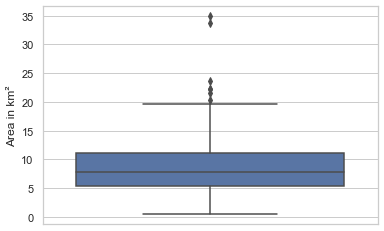

In [14]:
sns.set(style="whitegrid")
sns.boxplot(y='Area in km²', data=neighborhoods)

The distribution above shows us the that the size of 50% of the districts is between 5-12km2. Now, this will allows us to set a appropriate perimater for our radius of scan. Also, we have to keep in mind the limitation of the API provided by Foursquare which limit us to use a radius no bigger than 5000m. This means for the purpose of this project we will use a radius of 5000m.

#### Define Foursquare Credentials and Version
These are the creditials we will use in order to pull the data from the Foursquare API. Each one of them will be stored in a separate variable.

In [15]:
CLIENT_ID = 'X0UR5GR2EL3FBUPRBTPQW0M1XOECT3RPNNPUXEPACXEPO44J' 
CLIENT_SECRET = 'ANFDRV2DKSZG1J453PD3JW0V4DHM4FDKLR5UHFVDEW5IYFZO' 
VERSION = '20180605'

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

My credentails:
CLIENT_ID: X0UR5GR2EL3FBUPRBTPQW0M1XOECT3RPNNPUXEPACXEPO44J
CLIENT_SECRET: ANFDRV2DKSZG1J453PD3JW0V4DHM4FDKLR5UHFVDEW5IYFZO


#### Let's explore the first district in our dataframe and get the district lat and long values

In [16]:
neighborhood_name = neighborhoods.loc[0, 'District']
neighborhood_latitude = neighborhoods.loc[0, 'Lat'] 
neighborhood_longitude = neighborhoods.loc[0, 'Long'] 



print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Mitte are 52.51944399999999, 13.406667.


#### Now, let's get the top 100 venues that are in Mitte within a radius of 5000 meters.

In [17]:
LIMIT = 100 
radius = 5000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()


#### Function that extracts the category of the venue

In [18]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']  
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [19]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]


# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,Fat Tire Bike Tours,Bike Rental / Bike Share,52.521233,13.409110
1,19grams,Coffee Shop,52.522767,13.407041
2,Buchhandlung Walther König,Bookstore,52.521301,13.400758
3,Lustgarten,Garden,52.518469,13.399454
4,Father Carpenter,Coffee Shop,52.524469,13.406614


#### And how many venues from Mitte were returned by Foursquare?
We can see that we were able to pull exactly 100 venues from located in Mitte. This was also the maximum amount of venues that we are to pull.

In [20]:
(nearby_venues.shape[0])

100

### Explore the neighborhoods in Berlin
Now, let's do the same thing for all of the districts in Berlin by creating a function that will pull the data for us.

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
res=getNearbyVenues(names=neighborhoods.District, latitudes=neighborhoods.Lat,
                    longitudes=neighborhoods.Long)
res.head()

Mitte
Moabit
Hansaviertel
Tiergarten
Wedding
Gesundbrunnen
Friedrichshain
Kreuzberg
Prenzlauer Berg
Weißensee
Blankenburg
Heinersdorf
Karow
Stadtrandsiedlung Malchow
Pankow
Blankenfelde
Buch
Französisch Buchholz
Niederschönhausen
Rosenthal
Wilhelmsruh
Charlottenburg
Wilmersdorf


#### How many venues from Berlin were returned by Foursquare?
All of the venues that we were able to pull from the API are 1473 for all of the 96 districts in Berlin.

In [ ]:
berlin_venues = res
(berlin_venues.shape)

### Let's check how many different venues were returned for each neighborhood
This is done by grouping the names of the districts and counting the unique values of venue category.

In [ ]:
berlin_grouped=berlin_venues.groupby('Neighborhood').nunique('Venue Category')
berlin_grouped.head()

### Which borough(s) has the highest variaty of venues?
This will answer our first question in this project. We can do that by sorting the dataframe by the venue category.

In [ ]:
berlin_grouped = berlin_grouped.sort_values('Venue Category', ascending=False)
berlin_grouped.head()

As we can see Mitte has exactly 99 venues whithin 5000m with 66 different types of venues. Which is not surprising because the area is located in the heart of Berlin. We also noted that all neighborhoods have at least 1 venue.

### Analyze Each Neighborhood
Now, let's switch our attention to identifiying the type of vanues in each the districts. In order to do so, we will use the one hot encoding, which will convert the categorical values into numerical.

In [ ]:
# one hot encoding
bl_onehot = pd.get_dummies(berlin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bl_onehot['Neighborhood'] = berlin_venues['Neighborhood'] 

# move neighborhood column to the first column
cols = bl_onehot.columns.tolist()
cols.insert(0, cols.pop(cols.index('Neighborhood')))

bl_onehot = bl_onehot.reindex(columns= cols)
bl_onehot

### Estimating the appearnces of each venue by using the average function
This allows us to see how often a certain type of venue appear in a specific districts. In order to do so, we have grouped all of the districts by name, calculated their average and sorted them by alphabetical order.

In [ ]:
berlin_grouped = bl_onehot.groupby('Neighborhood').mean().reset_index()
berlin_grouped.head()

In [ ]:
berlin_grouped = berlin_grouped.drop('Neighborhood', axis=1)
berlin_grouped = berlin_grouped.astype(float)
(berlin_grouped.sum(axis=0).sort_values())

From the list above we can see that the most common venue's  categories are Supermarket , Bus Station, Café ,  Bakery and Italian Restaurant.

### What is the most common type of restaurants in Berlin?

This allowes us to answer the second question for our project. The Italian restaurant is the most common type of restaurant in Berlin.

### Explore all neighborhoods which is near to the art gallery
To be able to identify this we need just to filter the dataset we have from the one hot encoding about districts that have value in the column "Art Gallery" higher than 0. This indicates that in this district there is an Art Gallery.

In [ ]:
#get a list of a neighboorhoods names
art_buildings=bl_onehot[bl_onehot["Art Gallery"]>0].Neighborhood.unique().tolist()
art_buildings

In [ ]:
# subset all geo locations and highlight on the map:
bl_art_neighboors = berlin_venues[(berlin_venues["Neighborhood"].isin(art_buildings))]
bl_art_neighboors=bl_art_neighboors.iloc[:,0:3]
bl_art_neighboors.head()

In [ ]:
bl_art_neighboors.shape

In [ ]:
bl_art_neighboors=bl_art_neighboors.drop_duplicates()
bl_art_neighboors.shape

### Which borough(s) is near to Art Gallery?
Let's visualize the boroughs from Berlin in a map.

In [ ]:
map_bl = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(bl_art_neighboors['Neighborhood Latitude'], bl_art_neighboors['Neighborhood Longitude'], bl_art_neighboors['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bl)  
    
map_bl

As expected, most places, which are close to some art gelery, are located in the central parts of Berlin:
- Mitte
- Moabit
- Hansaviertel
- Kreuzberg
- Neukölln

<br></br>

However, two of the boroughs the are extremely far away from the city center also appear to be boroughs with Art Galleries:
- Wannsee
- Buch

# Results <a name="results"></a>

1. Which borough(s) has the highest variaty of venues?
 - Mitte is the borough that has exactly 99 venues whithin 5000m with 66 different types of venues. Which is not surprising because the area is located in the heart of Berlin. We also noted that all neighborhoods have at least 1 venue.
 


2. What is the most common type of restaurants in Berlin?
 - This allowes us to answer the second question for our project. The Italian restaurant is the most common type of restaurant in Berlin.
 


3. Which borough(s) is near to Art Gallery?
 - Mitte, Moabit, Hansaviertel, Kreuzberg, Neukölln, Wannsee, Buch

# Discussion <a name="discussion"></a>

During the work for this project we noticed several important things:
1. The API calls from Foursquare can be a very useful free tool to gather information for different cities, their venues and their distribution within the city. However, the limitation of the API calls for radios and number of venues return can falsify the results at the very end if you want to make a big aggragated analysis. If you want to get more detailed findings, you better use one of the paid options for Foursquare API calls. This will allow you to increase the radius of scan even more and at the same time to not have any overlapping in the scan.


2. The most center district in Berlin (Mitte) is the one that has the highest potential for spending a good short vacation in Berlin. Especially for the tourists that visit the city for a day or weekend. Even though this was a bit expected, now we can confirm that this is a valid assumption to make. It is also good to see that all of the districts in Berlin have at least one venue from the Foursquare database. This shows that the Foursquare can be considered a good source for relavant location data.


3. The influence of the different culture in Berlin can be seen by the numerous different types of restaurants in Berlin. The fact that Italian restaurants are the most common type of restaurant can show us that probably the Italian cousina is the most favourite one to the majority of people living in Berlin. 


4. Berlin is famous with it's countless art galleries and museums. One of the findings of this project that only a couple of central districts have a gallery. That was a fact that definately can guide the tourists who have an interest in art in which district they should go to.

# Conclusion <a name="conclusion"></a>

1. Limited findings due to the limited API's limitations.


2. Mitte is the best district in Berlin for tourists.


3. The Italian restaurants are the most common type of restaurant in Berlin.


4. There are only a handful of districts that have an Art Gallery.